In [1]:
#!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
#!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
#!pip install --upgrade youtube-dl

In [1]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

2024-03-20 06:06:25.684371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 06:06:26.102897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-03-20 06:06:26.102925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-20 06:06:26.158024: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable 

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

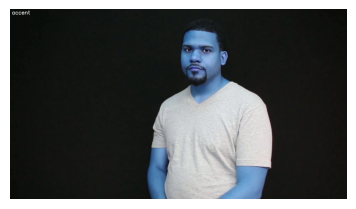

In [3]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('WLASL100_avi_augmentation/')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 1)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'WLASL100_avi_augmentation/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'WLASL100_avi_augmentation/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# Preprocessing Data

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
#IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128
IMAGE_HEIGHT , IMAGE_WIDTH = 32, 32

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 50

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "WLASL100_avi_augmentation/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
#CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

# Get the list of all folders (class names) in the dataset directory.
CLASSES_LIST = [folder for folder in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, folder))]

# Print the list of classes.
print(CLASSES_LIST)

['arm', 'animal', 'after', 'ago', 'age', 'army', 'also', 'anatomy', 'alarm', 'approve', 'aim', 'alphabet', 'ahead', 'area', 'arrogant', 'affect', 'act', 'allergy', 'admit', 'algebra', 'above', 'accept', 'apart', 'alligator', 'apple', 'accident', 'about', 'already', 'appropriate', 'adverb', 'arizona', 'alcohol', 'adult', 'archery', 'agreement', 'anniversary', 'actor', 'advanced', 'again', 'analyze', 'appreciate', 'answer', 'angle', 'appointment', 'against', 'a', 'afternoon', 'adjective', 'allow', 'angel', 'always', 'art', 'add', 'able', 'and', 'aid', 'april', 'almost', 'argue', 'arrest', 'activity', 'arrive', 'abdomen', 'a lot', 'admire', 'announce', 'alone', 'adapt', 'accountant', 'across', 'all day', 'adopt', 'amputate', 'article', 'angry', 'airplane', 'annoy', 'around', 'agenda', 'action', 'america', 'all', 'advantage', 'accent', 'another', 'approach', 'agree', 'address', 'appetite', 'apostrophe', 'adjust', 'anyway', 'africa', 'afraid', 'accomplish', 'any', 'appear', 'amazing', 'acti

# Create a Function to Extract, Resize & Normalize Frames

In [5]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

# Extract

In [6]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

# Create a Function for Dataset Creation 

In [7]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [8]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: arm
Extracting Data of Class: animal
Extracting Data of Class: after
Extracting Data of Class: ago
Extracting Data of Class: age
Extracting Data of Class: army
Extracting Data of Class: also
Extracting Data of Class: anatomy
Extracting Data of Class: alarm
Extracting Data of Class: approve
Extracting Data of Class: aim
Extracting Data of Class: alphabet
Extracting Data of Class: ahead
Extracting Data of Class: area
Extracting Data of Class: arrogant
Extracting Data of Class: affect
Extracting Data of Class: act
Extracting Data of Class: allergy
Extracting Data of Class: admit
Extracting Data of Class: algebra
Extracting Data of Class: above
Extracting Data of Class: accept
Extracting Data of Class: apart
Extracting Data of Class: alligator
Extracting Data of Class: apple
Extracting Data of Class: accident
Extracting Data of Class: about
Extracting Data of Class: already
Extracting Data of Class: appropriate
Extracting Data of Class: adverb
Extracting Data of C

# Sekarang kita akan mengonversi label menjadi one-hot encoded vector

In [ ]:
features=np.array(features)
labels=np.array(labels)
np.save('augmented_100_features_cnn3d',features)
np.save('augmented_100_labels_cnn3d',labels)
#a.shape

In [ ]:
import numpy as np

# Load labels and features
labels = np.load('augmented_100_labels_cnn3d.npy')
features = np.load('augmented_100_features_cnn3d.npy')

# Get the number of unique classes
num_classes = len(np.unique(labels))

print("Number of classes:", num_classes)


In [14]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# Split the Data into Train and Test Set

In [15]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.3, shuffle = True,
                                                                            random_state = seed_constant)

# Implement the Conv-LSTM Approach

In [16]:
from keras.regularizers import l2

def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.01)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [17]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

2024-03-19 18:17:34.346945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-19 18:17:34.347020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: yusuf-ridho-pod
2024-03-19 18:17:34.347027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: yusuf-ridho-pod
2024-03-19 18:17:34.347206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2024-03-19 18:17:34.347228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.161.3
2024-03-19 18:17:34.347234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 470.161.3 does not match DSO version 535.104.5 -- cannot find working devices in this configuration


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 50, 30, 30, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 50, 15, 15, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 50, 15, 15, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 50, 13, 13, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 50, 7, 7, 8)       0         
 g3D)                                                            
                                                        

In [18]:
# Plot the structure of the contructed model.
#plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Training

In [19]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 60, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 60, batch_size = 16,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/60
16/16 [==============================] - 43s 2s/step - loss: 4.6743 - accuracy: 0.0242 - val_loss: 4.6524 - val_accuracy: 0.0000e+00
Epoch 2/60
16/16 [==============================] - 25s 2s/step - loss: 4.6119 - accuracy: 0.0282 - val_loss: 4.6742 - val_accuracy: 0.0000e+00
Epoch 3/60
16/16 [==============================] - 24s 2s/step - loss: 4.5410 - accuracy: 0.0323 - val_loss: 4.7212 - val_accuracy: 0.0000e+00
Epoch 4/60
16/16 [==============================] - 24s 1s/step - loss: 4.4410 - accuracy: 0.0363 - val_loss: 4.8682 - val_accuracy: 0.0000e+00
Epoch 5/60
16/16 [==============================] - 24s 1s/step - loss: 4.3590 - accuracy: 0.0282 - val_loss: 5.0524 - val_accuracy: 0.0159
Epoch 6/60
16/16 [==============================] - 23s 1s/step - loss: 4.2611 - accuracy: 0.0524 - val_loss: 5.0604 - val_accuracy: 0.0000e+00
Epoch 7/60
16/16 [==============================] - 24s 1s/step - loss: 4.1460 - accuracy: 0.0323 - val_loss: 5.3774 - val_accuracy: 0.0000e

Epoch 59/60
16/16 [==============================] - 23s 1s/step - loss: 0.3184 - accuracy: 0.9315 - val_loss: 11.7549 - val_accuracy: 0.0476
Epoch 60/60
16/16 [==============================] - 22s 1s/step - loss: 0.3257 - accuracy: 0.9274 - val_loss: 12.1306 - val_accuracy: 0.0476


In [20]:
# Evaluate model on test data
test_loss, test_accuracy = convlstm_model.evaluate(x=features_test, y=labels_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Loss: 13.2891
Test Accuracy: 0.0075


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Prediksi kelas untuk data pengujian
y_pred_test = np.argmax(convlstm_model.predict(features_test), axis=1)

# Dapatkan kelas sebenarnya
y_true_test = np.argmax(labels_test, axis=1)

# Buat confusion matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Tampilkan confusion matrix
print("Confusion Matrix - Test Data:")
print(cm_test)

# Tampilkan laporan klasifikasi
print("\nClassification Report - Test Data:")
print(classification_report(y_true_test, y_pred_test))


5/5 [==============================] - 3s 476ms/step
Confusion Matrix - Test Data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
    

# Performance

In [22]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

5/5 [==============================] - 2s 479ms/step - loss: 13.2891 - accuracy: 0.0075


In [23]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstmminggu.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [24]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

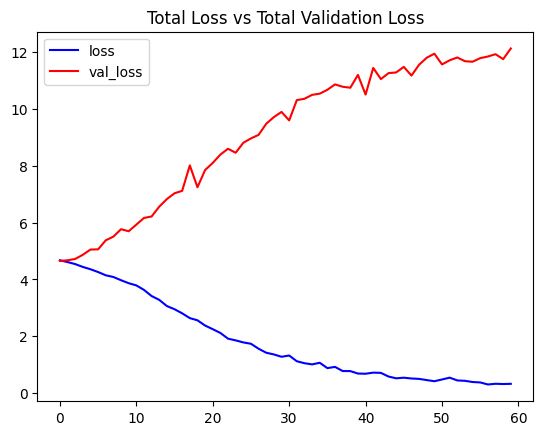

In [25]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

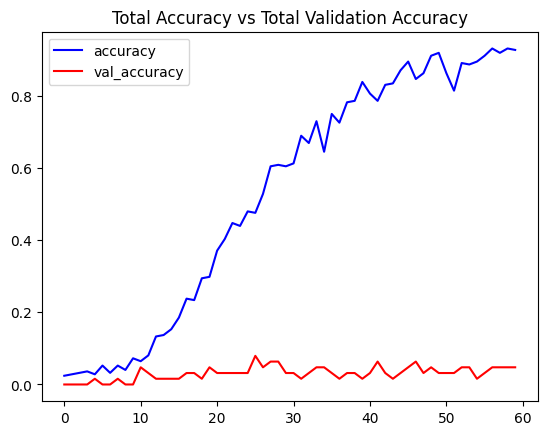

In [26]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

5/5 [==============================] - 3s 480ms/step


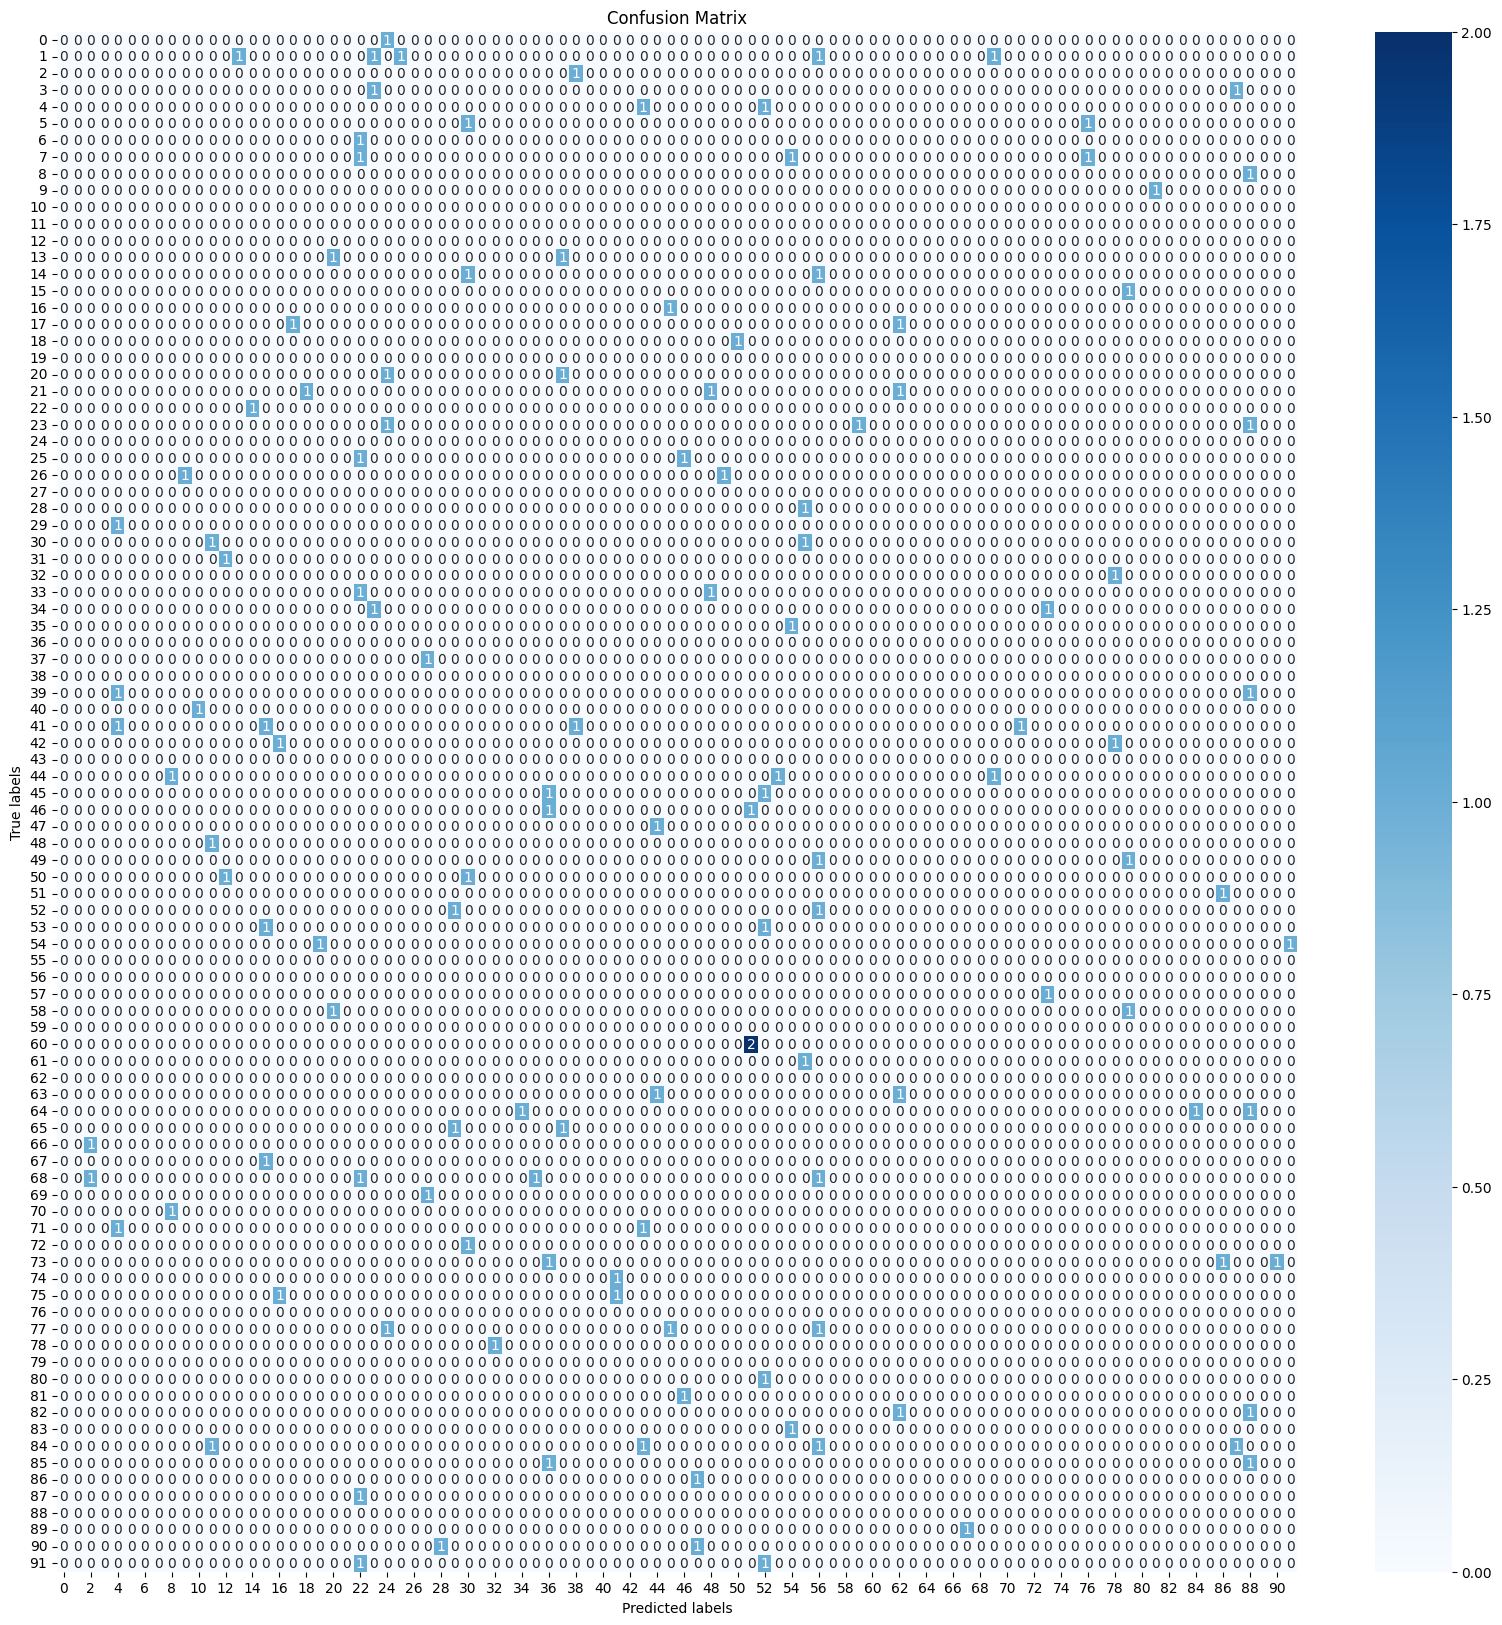

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from sklearn.model_selection import train_test_split

# Memuat model yang telah dilatih
model = load_model('convlstmminggu.h5')

# Memuat data fitur dan label yang telah dipisahkan
# Pastikan untuk mengganti features_train, features_test, labels_train, dan labels_test 
# dengan data fitur dan label yang telah Anda pisahkan
# features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2, shuffle=True, random_state=seed_constant)

# Melakukan prediksi menggunakan model pada data uji
y_pred_prob = model.predict(features_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Membuat confusion matrix
conf_matrix = confusion_matrix(np.argmax(labels_test, axis=1), y_pred)

# Menampilkan confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:
from keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import train_test_split

# Load model
model = load_model('convlstmminggu.h5')

# Load data uji
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

# Prediksi kelas menggunakan model
y_pred = np.argmax(model.predict(features_test), axis=1)

# Print classification report
print(classification_report(np.argmax(labels_test, axis=1), y_pred))


3/3 [==============================] - 3s 701ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          17       1.00     